<a href="https://colab.research.google.com/github/Tinashemuza/Data-Science/blob/main/Regression_Modeling_%26_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<font color=ORANGE> <center>**1. APPLICATION OF LINEAR REGRESSION ANALYSIS**



In [2]:
#Python Liabriaries
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression


Linear regression analysis is the most frequently used analytical technique in finance and is the foundation of many more advanced econometrics theories. In this section we will also cover the basic steps of implementing linear regression analysis. These basic steps are applicable to future advanced econometrics analyses.

#<font color=Orange>**Case Scenario - Equity Analyst**

Suppose you are an equity analyst in an asset management company and you trying to analyse the causes of the recent increase in Coca Cola's stock price and see if there is still potential for the price to continue growing

#<font color=black>**Project**

So in this project we need to research & identify potential factors that affect the performance of KO's stock price. Once we identify these factors we can start collecting data for analysis. Project Outline:

1. Identifying potential factors influencing KO's stock prices
2. Quantifying the relationship between Coca Cola stock prices and Selected factors

3. Forecasting the future stock price - using our developed regression model


Suppose we have identified the following three factors are most impactful on *KO*'s stock price: *KO*'s revenue, Pepsi's stock price, and the Dow Jones Industrial Average Index. We will use these three factors to create a linear regression model to predict *KO*'s next-day closing stock price.

We will make use of the stock excess return as our variable to analyze than the actual price. The excess return is the actual return minus risk-free interest rate (usually Treasury Bill Rates). Thus, we will convert all our variables into returns or ratios. In our modeling dataset, we will have the following variables:

> *KO*'s stock excess return (%) <br>
> *KO*'s sales growth (%) <br>
> *DOW 30* Index excess return (%) <br>
> *Pepsi*'s stock excess return (%)

In order to use comparable variables to conduct our modeling approach, all variables are quarterly ratios (quarterly excess returns and quarterly sales growth).

We will also need to decide which variables are dependent variables and which are independent variables. In our case, we want to build a regression model to understand and predict how *KO*'s stock excess return will move when the three factors change. *KO*'s stock excess return is an dependent variable. The other three variables are exogenous variables because their value is not decided by the model.

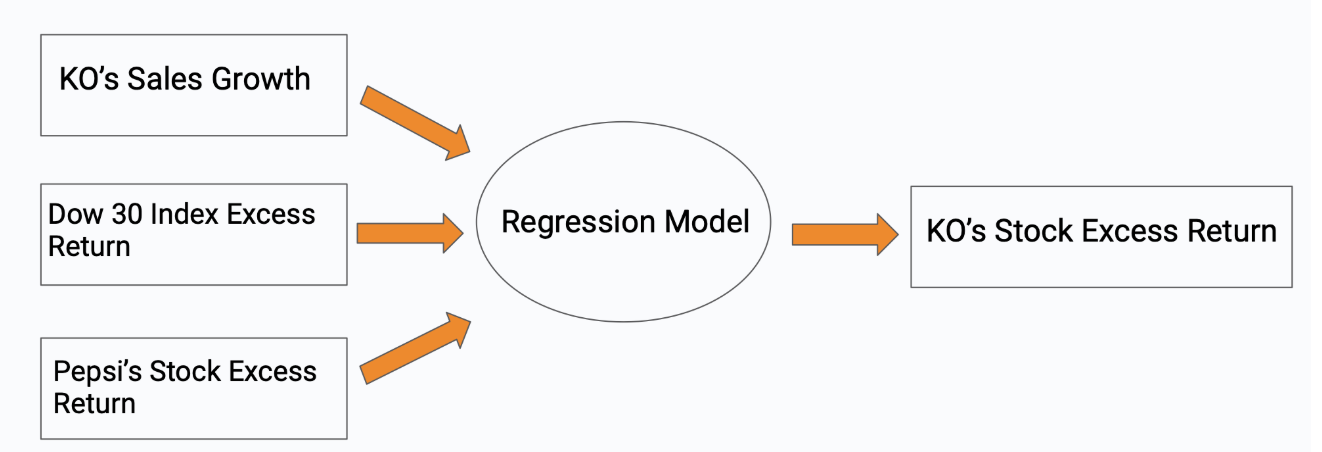

**Checking for the Relationship between Dependent variables and Independent variables**

After defining the dependent variables and independent variables for our regression model, we will use some graphical tools to investigate the relationships of our selected variables. This step give us information as to how to structure our regression model and decide if some selected variables and data points should be excluded. The graphic tool we will use is a **scatter plot**. A scatter plot is a two-dimensional graph with one variable on one axis and another variable on another axis. A scatter plot can show us the relationship of two variables. So what exactly is a scatter plot used for?

First, a scatter plot can check for the linear relationship between the endogenous variable and the exogenous variables. One of the assumptions in running regression analyses is that the endogenous variable has a linear relationship with exogenous variables. By looking at the scatter plot, we can determine if we can draw a straight line where most of the points will be around the line.

Second, a scatter plot can be used to check for independence between the endogenous variable and exogenous variables. Continuing from the previous paragraph, if the straight line drawn is either a horizontal line or a vertical line, it means no matter how much the value of one variable moves, the value of the other variable always stays within a tight range. In this case, the two variables are independent of each other. If an exogenous variable is independent of the endogenous variable, we should drop this exogenous variable from the model.

Lastly, a scatter plot can be used to find extreme points that are well-separated from the other points. There are two types of extreme points. One is called an outlier. An **outlier** is a point that doesn't follow the general trend of the other points. The other one is called a leverage point. A **leverage point** has extreme value for exogenous variables. Both types may or may not impact the estimated result of the regression model. Try to run one model with them and another model without them. Then, compare the two model results to see if these extreme points are crucial to the final model result.

**Figure 2: Scatter Plot**—**KO Stock Excess Return vs. Dow 30 Index Excess Return**

In [3]:
# Source historical data for KO and DOW 30 Index from yahoofinance
tickers = ['KO', '^DJI']
start_date = "2016-04-01"
end_date = "2021-09-30"

data = yf.download(tickers, start=start_date, end=end_date)['Close']

#We convert daily prices to quarterly closing prices
quarterly_prices = data.resample('Q').last()

#We calculate quarterly returns
quarterly_returns = quarterly_prices.pct_change().dropna()

#We calculate excess returns (subtracting 1% annual risk-free rate → 0.25% quarterly)
quarterly_rf = 0.01 / 4
quarterly_excess_returns = quarterly_returns - quarterly_rf
quarterly_excess_returns.columns = ['Coke_Q_EX_R', 'Dow_Q_EX_R']


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed
<ipython-input-3-37d19e23e290>:9: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_prices = data.resample('Q').last()


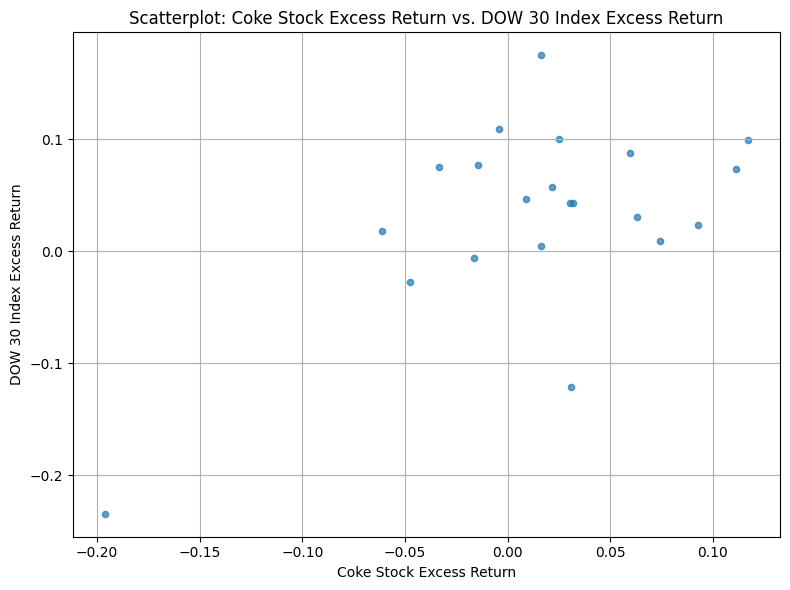

In [4]:
#Creating scatter plot
scatt = quarterly_excess_returns.plot.scatter(
    x="Coke_Q_EX_R",
    y="Dow_Q_EX_R",
    title="Scatterplot: Coke Stock Excess Return vs. DOW 30 Index Excess Return",
    figsize=(8, 6),
    grid=True,
    alpha=0.7
)
scatt.set_xlabel("Coke Stock Excess Return")
scatt.set_ylabel("DOW 30 Index Excess Return")
plt.tight_layout()
plt.show()


The scatterplot shows a positive relationship between Coca-Cola’s stock excess return and the Dow Jones Industrial Average excess return.


We can also use the **Pearson Correlation** metric to check the linear relationship of two variables. The value of the Pearson Correlation is between $-1$ and $1$. If the value of two variables tends to move in the same direction, the correlation is positive. If the two variables tend to move in opposite directions, the number is negative. A correlation of $1$ means the two variables have a perfectly positive linear relationship.

**Figure 3: Histogram, Correlation, and Scatter Plot Graph Matrix For Independent Variables and Dependent Variable**

In [5]:
#Revenue_Millions_USD
revenues = [
    11539, 10633, 9409, 9118,
    9702, 9078, 8314, 7626,
    9421, 8775, 8478, 8694,
    9997, 9507, 9068, 8601,
    7150, 8652, 8611, 9020,
    10129, 10042
]

# Convert to Series
revenue_series = pd.Series(revenues)

# Compute % change in revenue
REV_Q_R = revenue_series.pct_change().dropna() * 100

# Create quarterly date index
quarters = pd.date_range("2016-06-30", periods=len(revenues), freq="Q")
REV_Q_R.index = quarters[1:]  # exclude first because of dropna()

# Rename series
REV_Q_R.name = "REV_Q_R"

# Display
print(REV_Q_R)


2016-09-30    -7.851634
2016-12-31   -11.511333
2017-03-31    -3.092784
2017-06-30     6.404913
2017-09-30    -6.431664
2017-12-31    -8.415951
2018-03-31    -8.275198
2018-06-30    23.537897
2018-09-30    -6.857022
2018-12-31    -3.384615
2019-03-31     2.547771
2019-06-30    14.987348
2019-09-30    -4.901470
2019-12-31    -4.617650
2020-03-31    -5.149978
2020-06-30   -16.870131
2020-09-30    21.006993
2020-12-31    -0.473879
2021-03-31     4.749739
2021-06-30    12.294900
2021-09-30    -0.858920
Freq: QE-DEC, Name: REV_Q_R, dtype: float64


<ipython-input-5-eecaf27f8e6d>:18: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarters = pd.date_range("2016-06-30", periods=len(revenues), freq="Q")


For the data source above for Coca Cola Quarterly revenue, l have realed heavly on macrotrend website[macrotrend](https://www.macrotrends.net/stocks/charts/KO/cocacola/revenue?utm_source=chatgpt.com)

In [6]:
#Yahoo finance data for KO, Pepsi (PEP), and DOW 30 Index (^DJI)
tickers = ['KO', 'PEP', '^DJI']
data = yf.download(tickers, start=start_date, end=end_date)['Close']

# Convert daily prices to quarterly (last price of each quarter)
quarterly_prices = data.resample('Q').last()

# Compute quarterly returns
quarterly_returns = quarterly_prices.pct_change().dropna()

# Compute quarterly excess returns (assuming 1% annual risk-free rate)
risk_free_rate_q = 0.01 / 4
excess_returns = quarterly_returns - risk_free_rate_q

# Rename columns
excess_returns.columns = ['KO_Q_EX_R', 'Pepsi_Q_EX_R', 'Dow_Q_EX_R']

# Display the result
#print(excess_returns.head())

[*********************100%***********************]  3 of 3 completed
<ipython-input-6-754a527f4220>:6: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_prices = data.resample('Q').last()


In [7]:
# Function to calculate correlation coefficient between two arrays
def corr(x, y, **kwargs):
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r"$\rho$ = " + str(round(coef, 2))

    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy=(0.3, 0.15), size=20, xycoords=ax.transAxes)

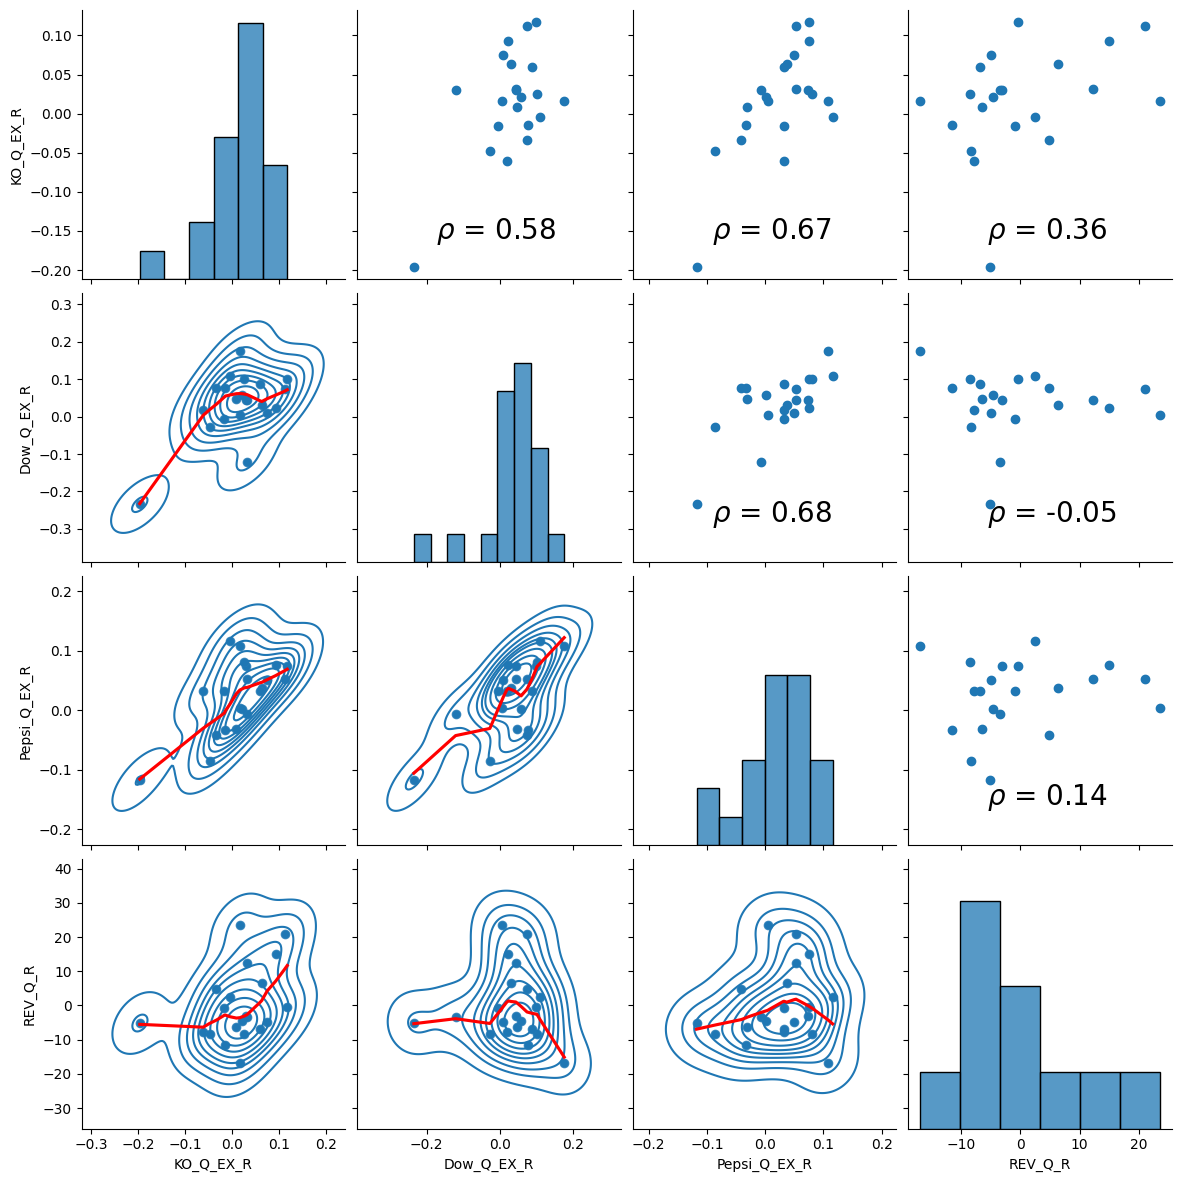

In [8]:
# Assuming both excess_returns and REV_Q_R have the same quarterly date index
# Combine the excess_returns DataFrame and the REV_Q_R Series into a single DataFrame
data_set = excess_returns.copy() # Create a copy to avoid modifying the original DataFrame
data_set['REV_Q_R'] = REV_Q_R

# Create the default pairplot
grid = sns.pairplot(
    data_set, vars=['KO_Q_EX_R','Dow_Q_EX_R','Pepsi_Q_EX_R','REV_Q_R'], height=3
)

# A scatter plot and Pearson correlation coefficient to the upper triangle
grid = grid.map_upper(plt.scatter)
grid = grid.map_upper(corr)

# Map a histogram to the diagonal
# grid = grid.map_diag(plt.hist)

# Map a density plot and regression line to the lower triangle
grid = grid.map_lower(sns.kdeplot)
grid = grid.map_lower(sns.regplot, lowess=True, line_kws={"color": "red"})

Data Period: 2016Q2 – 2021Q3
Data Source: Yahoo Finance and Coca Cola's website
KO_Q_EX_R: KO Quarterly Stock Excess Return
Dow_Q_EX_R: DOW 30 Index Quarterly Excess Return
Pepsi_Q_EX_R: Pepsi Quarterly Stock Excess Return
REV_Q_R: KO Quarterly Revenue change %



Figure 3 provides a summary of the relationships of variables in *KO*'s stock excess return analysis. The matrix is split into three parts.

* The lower left triangle of the matrix shows the scatter plots for all two-way combinations of the four variables.
* The graphs of the diagonal of the matrix are the histograms of the four variables.
* The upper right triangle of the matrix provides the correlation values of all two-way combinations of the four variables.

The scatter plot from the *KO* return and *Dow* return shows the two variables have a good positive linear relationship, as is the case for the *KO* return and Pepsi return. In both scatter plots, the data points also form an oval shape, more or less. The red line is also tilted upward. These signs suggest these two variables are good choices for modeling *KO*'s return. In the scatter plot for *KO*'s return and *KO*'s revenue growth, we don't see as clear an oval shape, and the red line is not as straight and sloped upward as the other two graphs. Their correlation values on the upper right also confirm the information from the graphs. Dow return and Pepsi return have good positive correlation values with *KO*'s return. However, *KO*'s revenue growth and return have a smaller correlation.

## **Estimate the Regression Model**

We are going to use the ordinary least square (OLS) linear regression. We have two types of OLS linear regression models:

1. **Simple OLS**

2. **Multiple OLS**.

If there is only one independent variable, then it is called simple OLS linear regression and if there are more than one independent variable then it is called multiple OLS linear regression. Since we have three exogenous variables for our model, we will build a multiple OLS linear regression.

Here is the linear regression model we are going to estimate:

$$ \text{KO excess return} = b_0 + b_1 \text{Dow excess return} + b_2 \text{Pepsi excess return} + b_3 \text{KO revenue growth} $$

$b_0$, $b_1$, $b_2$ and $b_3$ are called **parameters** or **coefficients**. We will use the OLS method to estimate the values of parameters in the model. Once the values of the parameters are obtained from the OLS calculation, we call these values **estimates**

**OLS Linear Regression Result for KO Excess Return Model**

In [9]:
import statsmodels.formula.api as smf

# Fit the multiple OLS regression model
result = smf.ols(
    formula="KO_Q_EX_R ~ Dow_Q_EX_R + Pepsi_Q_EX_R+REV_Q_R",
    data=data_set
).fit()

# Display summary results
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              KO_Q_EX_R   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     7.446
Date:                Mon, 09 Jun 2025   Prob (F-statistic):            0.00215
Time:                        12:35:50   Log-Likelihood:                 35.882
No. Observations:                  21   AIC:                            -63.76
Df Residuals:                      17   BIC:                            -59.59
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0035      0.012     -0.305      0.764      -0.028       0.021
Dow_Q_EX_R       0.2542      0.176      1.441      0.168      -0.118       0.626
Pepsi_Q_EX_R     0.4574      0.251      1.823      0.086      -0.072       0.987
REV_Q_R          0.0020      0.001      1.929      0.071      -0.000       0.004
==============================================================================
Omnibus:                        0.883   Durbin-Watson:                   2.103
Prob(Omnibus):                  0.643   Jarque-Bera (JB):                0.772
Skew:                          -0.178   Prob(JB):                        0.680
Kurtosis:                       2.131   Cond. No.                         278.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
# Parameters with 6 significant digits
result.summary2().tables[1]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,-0.003546,0.011612,-0.305350,0.763807,-0.028045,0.020953
Dow_Q_EX_R,0.254162,0.176340,1.441318,0.167662,-0.117883,0.626206
Pepsi_Q_EX_R,0.457350,0.250911,1.822759,0.085977,-0.072026,0.986726
REV_Q_R,0.002045,0.001061,1.928593,0.070651,-0.000192,0.004283


The result above of the regression. The estimate for Dow excess return is 0.254162. It means when Dow excess return increases by 0.003 (0.003%), *KO* excess return will increase by 0.003 (0.003%).

## **Model Review**


So we are now assessing how good our estimated model is. We have several tests to assess and test the fitness of our model.But, we will first look at performance of each independent variable in the model and then assess the overall model fit.

**a. Performance of Each Independent Variable**

Under the section of coefficient in the result table, there is a column called *Pr(>|t|)*. This column shows $p$-values for each coefficient. A $p$-value is a metric to indicate whether the independent variable can explain the change of the dependent variable. The lower the number of the $p$-value, the better the explanatory ability this independent variable has regarding the dependent variable. In many research projects, $0.05$ is the level that determines whether an independent variable is significant. From our result, we had no independent variable that was significant, that is, less than < 0.05. Does that mean we can just drop the three variables from the model? There are at least two points we can consider before we make that decision.

1. **Does KO's excess return and KO's revenue growth exhibit a linear relationship?**

From the scatter plot for both variables, we know they have a weak linear relationship. Can we transform *KO*'s revenue growth into a different data series and then check the relationship again? We can try to take the square root or the logarithm of *KO*'s revenue growth and draw the scatter plot again.

2. **Are independent variables also correlated to each other?**

The correlation between Dow excess returns and Pepsi excess returns is 0.68 based on the scatter plot matrix. The two variables are medium positively correlated. When there are two or more correlated independent variables in a regression model, oftentimes, the independent variable with a higher correlation to the dependent variable will absorb all the explanatory ability from other correlated independent variables, making other correlated independent variables not significant in the model.

The above two points help us rethink our choice of independent variables in the model and the way to handle them.

**b. $R^2$ and Adjusted $R^2$**

We can now look at the general model fit. $R^2$ ,the coefficient of determination, is a commonly used metric to assess the model fit. $R^2$ tells us how much of the variation in the dependent variable can be explained by the variation of all independent variables in the model. The value of $R^2$ is between $0$ and $1$. If $R^2$ is $1$, it means the model perfectly explains the *KO* excess return behavior. Thus, given a set of numbers from all independent variables, the model can 100% correctly produce the number for the dependent variable. In general, the higher the value of $R^2$, the better the model fit.

In our model, the $R^2$ is 0.568. It means that the change in Dow excess return, Pepsi excess return, and *KO* revenue growth together can explain 57% of the change in *KO* excess return.

As an equity analyst, if management thinks 0.568 is not satisfactory, we may be asked to improve the model. Usually, adding a new independent variable is an easy starting point. Adding more independent variables to a model usually improves the model's $R^2$. However, it can cause the issue of a model overfitting. What is model overfitting? It means the model can do an excellent job predicting the endogenous variable from the data sample that is used to build the model. However, when you put a different dataset with the dependent variable and independent variables into the model, the model will give a poor forecast of the dependent variable with the new values for the independent variables.

An **adjusted $R^2$** can address this issue. What does an adjusted $R^2$ intend to adjust? Although adding new independent variables to a regression model will never lower $R^2$, it will add complexity to the model. It can also cause the model overfitting issue as described above. Hence, we have to ask if the extra complexity added to the model is worth it. This is what an adjusted $R^2$ does. Like $R^2$, an adjusted $R^2$ is between 0 and 1. An adjusted $R^2$ is always lower than $R^2$. An adjusted $R^2$ will increase if the degree of improvement from adding one exogenous variable is greater than the penalty imposed by one additional exogenous variable to the model.

In our OLS model, the adjusted $R^2$ is 0.492. It is hard to tell if this is a good adjusted $R^2$. We usually builds several versions of the regression models and then compares their adjusted $R^2$ to pick a final model. Model building and tweaking is an iterative process; it is rarely the case that the first model is the best model for any project.

#<font color=ORANGE> <center>**Other Crucial Concepts**

**c. Outliers and Influence**

We reviewed the performance of the independent variables in the model and of the model as a whole. We will now look into the impact of each data point from the data sample used to build the regression model.

In the scatter plot section, we discussed extreme values in the dataset. We introduced outliers and leverage points. Not all of them will influence the result of the regression model. The following visual examples demonstrate how an extreme data point can impact the regression result. The red dot is the extreme point. The black line is the regression line without the extreme point. The red line is the regression line with the extreme point.

**Impact of an Outlier on the Regression Model Result**


We reviewed the performance of the independent variables in the model and of the model as a whole. We will look into the impact of each data point from the data sample used to build the regression model.

In the scatter plot section, we examine extreme values in the dataset. Not all of them will influence the result of the regression model. The following visual examples demonstrate how an extreme data point can impact the regression result. The red dot is the extreme point and the black line is the regression line without the extreme point. The red line is the regression line with the extreme point.

In [12]:
# Generate 30 random points
np.random.seed(42)
n = 30
x = np.random.uniform(0, 5, n)
y = 1 + 3 * x + np.random.normal(0, 1, n)

# Add outlier at (2.5, 17)
x_with_out = np.append(x, 2.5)
y_with_out = np.append(y, 17)

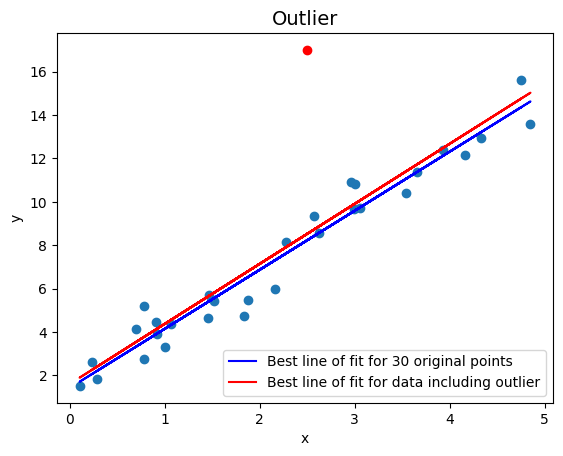

In [14]:
# Plot best line of fit for 30 original points only (in black) and for 30+outlier (in red)
plt.title("Outlier", {"size": 14})
plt.plot(x, y, "o")  # scatterplot
plt.plot(2.5, 17, "ro")  # Outlier in red

# line of fit for 30 original points only
(a, b) = np.polyfit(x, y, 1)
plt.plot(x, a * x + b, "b-", label="Best line of fit for 30 original points")

# line of fit for 30+outlier
(ao, bo) = np.polyfit(x_with_out, y_with_out, 1)
plt.plot(
    x_with_out,
    ao * x_with_out + bo,
    "r-",
    label="Best line of fit for data including outlier",
)

plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="lower right")

**Impact of a Non-Influential Leverage Point on the Regression Model Result**


In [15]:
# Add non-influential leverage point at (8, 25)
x_with_lev = np.append(x, 8)
y_with_lev = np.append(y, 25)

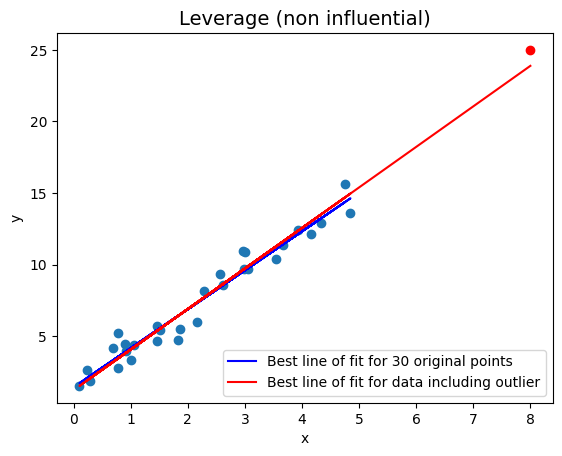

In [16]:
# Plot best line of fit for 30 original points only (in black) and for 30+lev (in red)
plt.title("Leverage (non influential)", {"size": 14})
plt.plot(x, y, "o")  # scatterplot
plt.plot(8, 25, "ro")  # non-influential outlier in red

# line of fit for 30 original points only
(a, b) = np.polyfit(x, y, 1)
plt.plot(x, a * x + b, "b-", label="Best line of fit for 30 original points")

# line of fit for 30+outlier
(al, bl) = np.polyfit(x_with_lev, y_with_lev, 1)
plt.plot(
    x_with_lev,
    al * x_with_lev + bl,
    "r-",
    label="Best line of fit for data including outlier",
)

plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="lower right")
plt.show()

**Impact of an Influential Leverage Point on the Regression Model Result**

In [17]:
# Add non-influential leverage point at (8, 25)
x_with_inf = np.append(x, 8)
y_with_inf = np.append(y, 5)

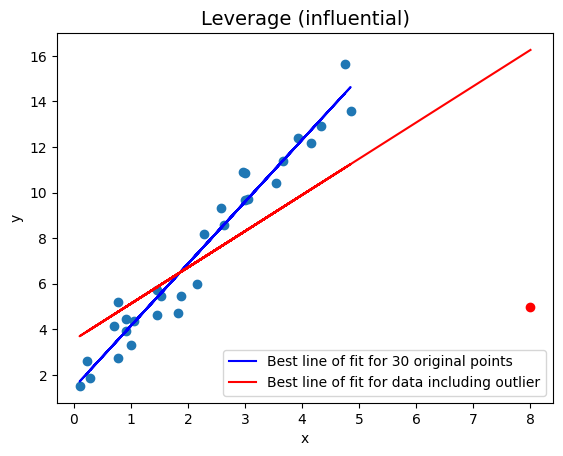

In [18]:
# Plot best line of fit for 30 original points only (in black) and for 30+lev (in red)
plt.title("Leverage (influential)", {"size": 14})
plt.plot(x, y, "o")  # scatterplot
plt.plot(8, 5, "ro")  # influential outlier in red

# line of fit for 30 original points only
(a, b) = np.polyfit(x, y, 1)
plt.plot(x, a * x + b, "b-", label="Best line of fit for 30 original points")

# line of fit for 30+outlier
(ai, bi) = np.polyfit(x_with_inf, y_with_inf, 1)
plt.plot(
    x_with_inf,
    ai * x_with_inf + bi,
    "r-",
    label="Best line of fit for data including outlier",
)

plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="lower right")
plt.show()

We can see the regression lines don't change much with or without the extreme point. However, we can see that extreme point does significantly alter the regression result. An extreme point that can significantly alter the regression result is called an **influential point**. We need to identify influential points in the dataset and study why they are extreme (a special event or erroneous data input) because they can potentially alter the regression result. Then, we will run one model with the influential point and one without the influential point. Afterwards, we compare the model results and evaluate which results fit our modeling goal the best.

We use **Cook's distance (Cook's D)** to identify influential points in the dataset. *Cook's D* is a metric to calculate the prediction difference from the model with a data point and without a data point. The higher the *Cook's D*, the greater the influence the data point has on estimating the regression model. Oftentimes, a data point with a *Cook's D* larger than 1 is considered an influential point.

**Influence Plot for KO's Excess Return Dataset**


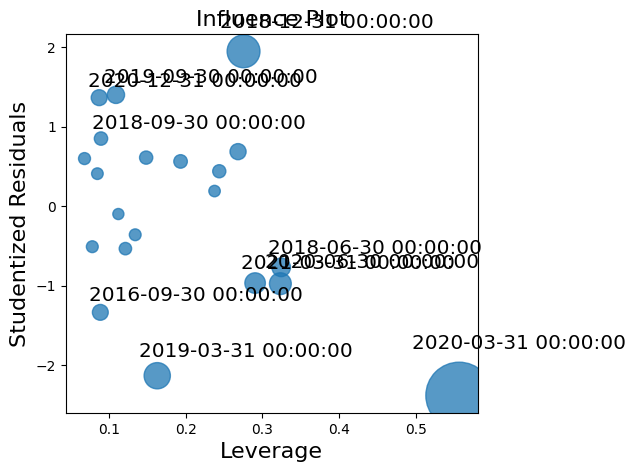

In [20]:
# Influence plot
fig = sm.graphics.influence_plot(result, criterion="cooks", alpha=0.5)
fig.tight_layout(pad=1.0)

In [21]:
# Finding most influential points
influence = result.get_influence()
inf_sum = influence.summary_frame().sort_values("cooks_d", ascending=False)
inf_sum.head(30)

,dfb_Intercept,dfb_Dow_Q_EX_R,dfb_Pepsi_Q_EX_R,dfb_REV_Q_R,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
Date,,,,,,,,,,
2020-03-31,-1.638727,1.731439,0.132964,0.457903,1.398432,-2.111046,0.556576,-2.365106,-2.384233,-2.671170
2018-12-31,0.685803,-1.054682,0.556010,-0.328892,0.309907,1.805542,0.275497,1.113386,1.948382,1.201468
2019-03-31,-0.184559,0.088561,-0.622372,-0.004184,0.183513,-1.941554,0.162989,-0.856768,-2.135126,-0.942187
2020-06-30,-0.046030,-0.175322,-0.187415,0.430804,0.114300,-0.977815,0.323492,-0.676164,-0.976477,-0.675239
2021-03-31,-0.281950,-0.468255,0.537925,-0.249777,0.096437,-0.970446,0.290579,-0.621086,-0.968685,-0.619958
2018-06-30,-0.236626,-0.067653,0.145755,-0.487562,0.073075,-0.779925,0.324567,-0.540646,-0.770549,-0.534147
2019-09-30,0.270552,-0.293368,0.322046,-0.225746,0.056870,1.362591,0.109148,0.476948,1.400602,0.490253
2020-09-30,0.136953,0.110657,-0.051305,0.364740,0.044471,0.696465,0.268323,0.421763,0.685521,0.415135
2020-12-31,0.170838,0.082902,0.139403,-0.030525,0.042408,1.331627,0.087310,0.411862,1.365019,0.422190


Above is an **influence plot.** which helps us visualize the *Cook's D* among all data points. On the horizontal axis of the plot is hat value. Hat value measures the difference between the exogenous values of a data point and the mean of exogenous values in the dataset. On the vertical axis of the plot is studentized residuals. These are the standardized residuals from the predicted endogenous value of the data point from the model. The bubbles in the plot indicate the size of the *Cook's D* for each point. The bigger the bubble, the higher the *Cook's D* for a data point.

From the influence plot, we can see that Point 15 and Point 18 have the highest *Cook's D* values. Among the points, Point 15 has a *Cook's D* of 1.21, so we consider it an influential point.